In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import sys
sys.path.append('../')
import utils
import plotting

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

# Data

## Import data

In [2]:
data_path = '/net/fs03/d1/emfreese/GCrundirs/nuclearproj/'

normal_model_path = 'NA_normal_2016'
nonuc_model_path = 'NA_nonuc_2016'

output_path = '/merra2_05x0625_tropchem_na/OutputDir/'

speciesconc_output = 'GEOSChem.SpeciesConc.2016*.nc4'
aerosol_output = 'GEOSChem.AerosolMass.2016*.nc4'


ds_nonuc = xr.open_mfdataset(data_path+nonuc_model_path+output_path+aerosol_output, combine='by_coords')
ds_normal = xr.open_mfdataset(data_path+normal_model_path+output_path+aerosol_output, combine='by_coords')

KeyboardInterrupt: 

In [5]:
ds = xr.concat([ds_nonuc,ds_normal], pd.Index(['nonuc_model','normal_model'], name='model_name'))

In [6]:
ds = ds.isel(lev = 0)

In [3]:
ds_gas = xr.open_zarr('./data/GC_output.zarr')

In [3]:
ds_hourlyo3 = xr.open_zarr('./data/hourly_O3_output.zarr/')

In [4]:
ds_OH = xr.open_zarr('./data/OH_restart.zarr/')

## OH Levels

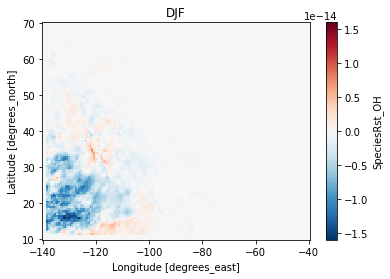

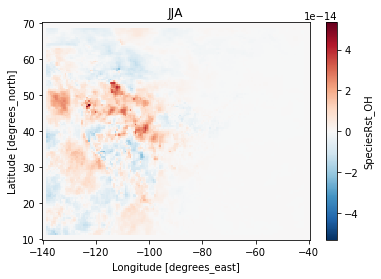

In [17]:
for m in ['DJF','JJA']:
    fig, ax = plt.subplots()
    (ds_OH['SpeciesRst_OH'].groupby('time.season').mean().sel(model_name = 'nonuc').sel(season = m)-
     ds_OH['SpeciesRst_OH'].groupby('time.season').mean().sel(model_name = 'normal').sel(season = m)).plot()
    plt.title(m)

## Hourly Ozone

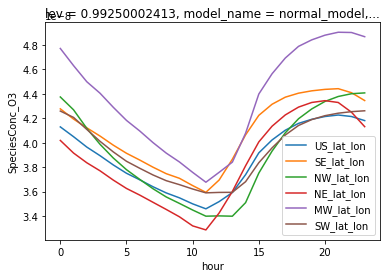

In [51]:
for lat_lon in utils.lat_lon_dict.keys():
    ds_hourlyo3.sel(lat = slice(utils.lat_lon_dict[lat_lon][2], utils.lat_lon_dict[lat_lon][3]), 
       lon = slice(utils.lat_lon_dict[lat_lon][0], utils.lat_lon_dict[lat_lon][1])).groupby('time.hour').mean(
        dim = ['lat','lon','time']).isel(lev = 0, ilev = 0).sel(model_name = 'normal_model')['SpeciesConc_O3'].plot(label = lat_lon)
    plt.legend()

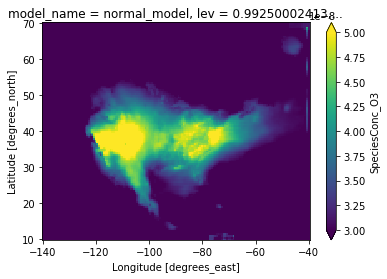

In [42]:
ds_hourlyo3.groupby('time.hour').mean(
        dim = ['time']).isel(lev = 0, ilev = 0).sel(hour = slice(10,18)).mean(dim = 'hour').sel(model_name = 'normal_model')['SpeciesConc_O3'].plot(vmin = 3e-8, vmax = 5e-8)

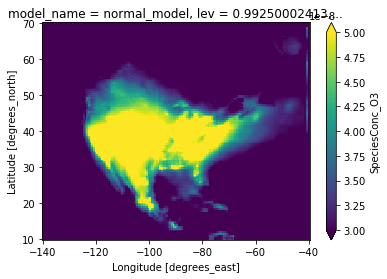

In [43]:
ds_hourlyo3.groupby('time.hour').mean(
        dim = ['time']).isel(lev = 0, ilev = 0).sel(hour = slice(19,24)).mean(dim = 'hour').sel(model_name = 'normal_model')['SpeciesConc_O3'].plot(vmin = 3e-8, vmax = 5e-8)

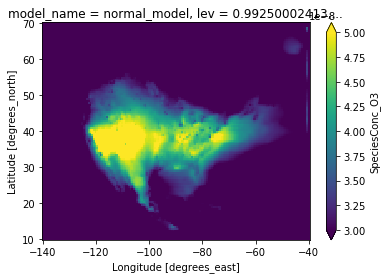

In [44]:
ds_hourlyo3.groupby('time.hour').mean(
        dim = ['time']).isel(lev = 0, ilev = 0).sel(hour = slice(0,9)).mean(dim = 'hour').sel(model_name = 'normal_model')['SpeciesConc_O3'].plot(vmin = 3e-8, vmax = 5e-8)

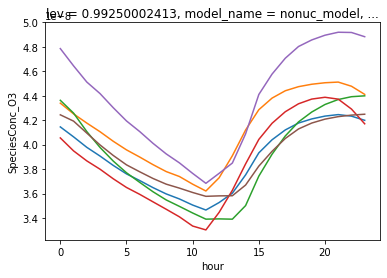

In [46]:
for lat_lon in utils.lat_lon_dict.keys():
    ds_hourlyo3.groupby('time.hour').mean(
        dim = ['lat','lon','time']).isel(lev = 0, ilev = 0).sel(model_name = 'normal_model')['SpeciesConc_O3'].plot(label = lat_lon)
    plt.legend()

## PM25 calcuations and data conversions
PM25     = 1.33 (NH4 + NIT  + SO4)
         + BCPI + BCPO
         + 2.1 (OCPO + 1.16 OCPI) + 1.16 SOA
         + DST1 + 0.38 DST2 + 1.86 SALA

In [19]:
#### convert to ug from ppb

# molecular weights of species
mw_species = {
    'AerMassNH4': 18.,
    'AerMassNIT': 62.,
    'AerMassSO4': 96.,
    'AerMassBC': 12.,
    'TotalOC': 12.,
}
#list of pm species
pm_species = list(mw_species.keys())
#ds = ds.rename({'AerMass' + spec: spec for spec in ['NH4','NIT','SO4','BC','SAL']})
#ds = ds.rename({'Total' + spec: spec for spec in ['OC']})

#update ds
ds = utils.ppb_to_ug(ds, ['AerMassNH4','AerMassNIT','AerMassSO4','AerMassBC'], mw_species)

#add column for calculated PM
ds['calc_PM25'] = (1.33 * (ds['NH4'] + ds['NIT'] + ds['SO4'])
                     + (ds['BCPO'] + ds['BCPI'])
                     + 2.1*(ds['OCPO'] + 1.16*ds['OCPI'])
                     + ds['DST1'] + 0.38*ds['DST2']
                     + 1.86*ds['SALA'])
#add column for inorganic PM
ds['inorganic_PM25'] = (1.33 * (ds['NH4'] + ds['SO4'] + ds['NIT']))
ds['inorganic_PM25'].attrs['units'] = 'μg m-3'

#add column for organic PM
ds['organic_PM25'] = ((ds['BCPO'] + ds['BCPI'])
                     + 2.1*(ds['OCPO'] + 1.16*ds['OCPI'])
                     + ds['DST1'] + 0.38*ds['DST2']
                     + 1.86*ds['SALA'])
ds['organic_PM25'].attrs['units'] = 'μg m-3'


ds['calc_PM25'].attrs.update({
    'units': 'μg m-3', 'full_name': 'Total PM2.5', 'name': 'PM25'
})
ds['monthly_mean_calc_PM25'] = ds['calc_PM25'].groupby('time.month').mean()
ds['monthly_mean_calc_PM25'].attrs.update({'units':'μg m-3', 'full_name': 'Monthly Mean PM2.5', 'name': 'PM25'})
ds['monthly_mean_inorganic_PM25'] = ds['inorganic_PM25'].groupby('time.month').mean()
ds['monthly_mean_inorganic_PM25'].attrs.update({'units':'μg m-3', 'full_name': 'Monthly Mean Inorganic PM2.5', 'name': 'PM25'})
ds['monthly_mean_organic_PM25'] = ds['organic_PM25'].groupby('time.month').mean()
ds['monthly_mean_organic_PM25'].attrs.update({'units':'μg m-3', 'full_name': 'Monthly Mean Organic PM2.5', 'name': 'PM25'})
for species in pm_species:
    ds[f'monthly_mean_{species}'] = ds[f'{species}'].groupby('time.month').mean()
    ds[f'monthly_mean_{species}'].attrs.update({'units':'μg m-3', 'full_name': f'Monthly Mean {species}', 'name': f'{species}'})

# PM Plots
#### Diagnose location and PM component of the large hot-spots of PM

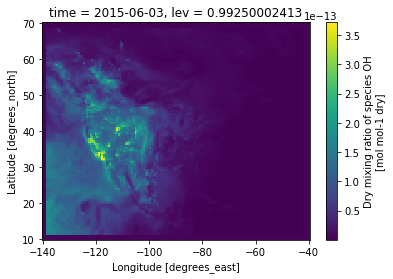

In [65]:
dtest['SpeciesRst_OH'].isel(lev = 0).plot()

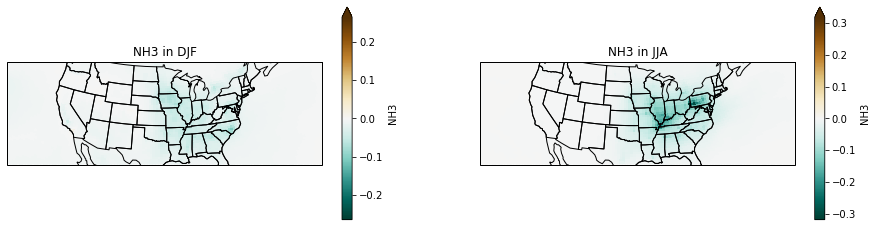

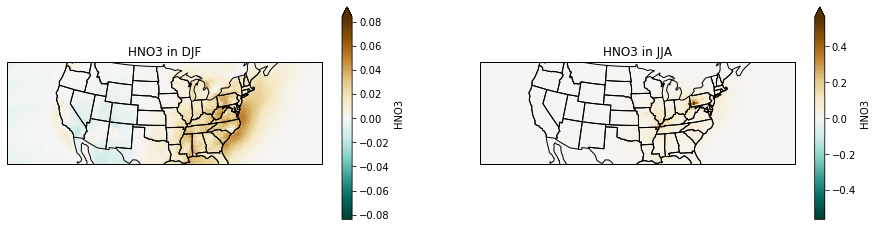

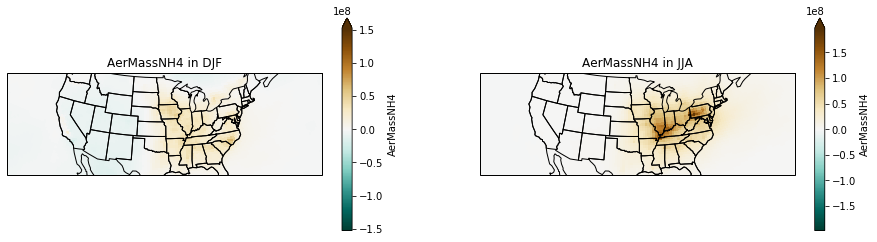

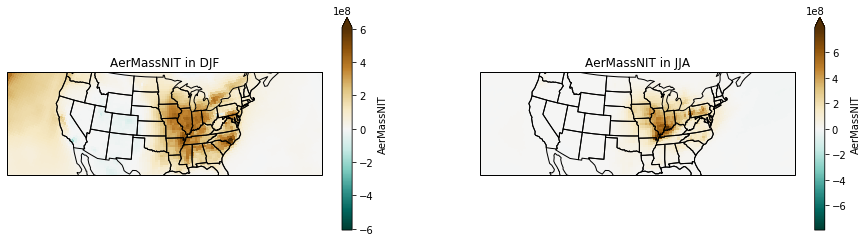

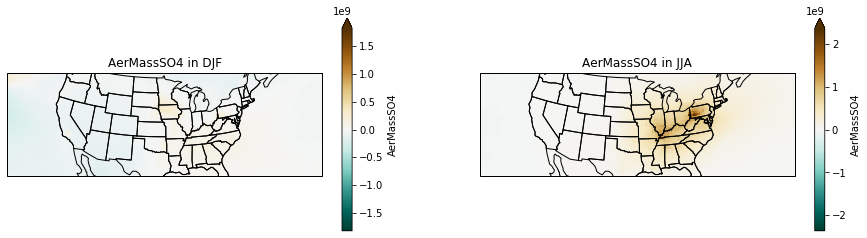

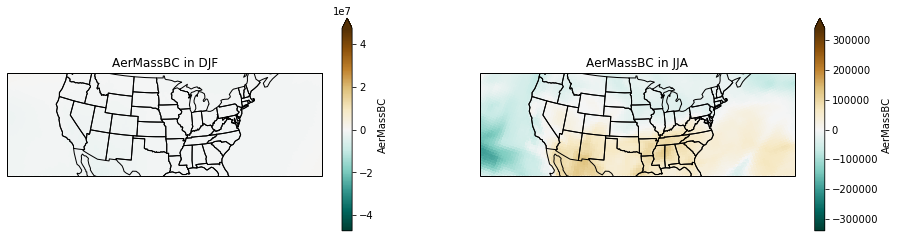

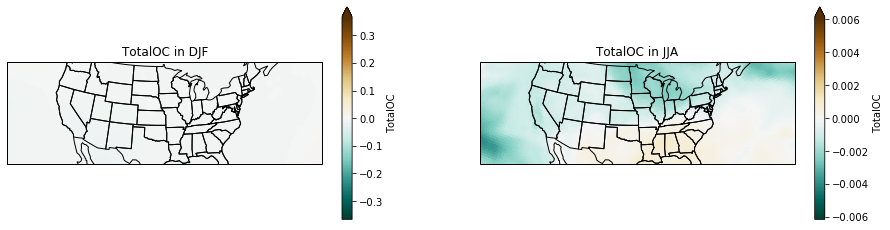

In [20]:
for species in ['NH3','HNO3']:
    plotting.seasonal_mean((ds_gas.sel(model_name = 'nonuc_model')-ds_gas.sel(model_name = 'normal_model')), species, utils.lat_lon_dict['US_lat_lon'], 'BrBG_r')
    
for species in mw_species.keys():
    plotting.seasonal_mean((ds.sel(model_name = 'nonuc_model')-ds.sel(model_name = 'normal_model')), species, utils.lat_lon_dict['US_lat_lon'], 'BrBG_r')

In [ ]:
plotting.concentration_plot_seasonal_dif(ds = ds, seasons = ['JJA','DJF'], species_names = ['NH3','NH4'], cmap = cmap_dif,
                   rows = 2, columns = 2, levels = np.arange(-0.3,0.3,.001), lat_lon = [-120,-70,20,50],
                   figsize = [10, 5], extension = 'both')
#plt.savefig('./Figures/NH3_NH4_dif.png', bbox_inches = 'tight', dpi = 150)

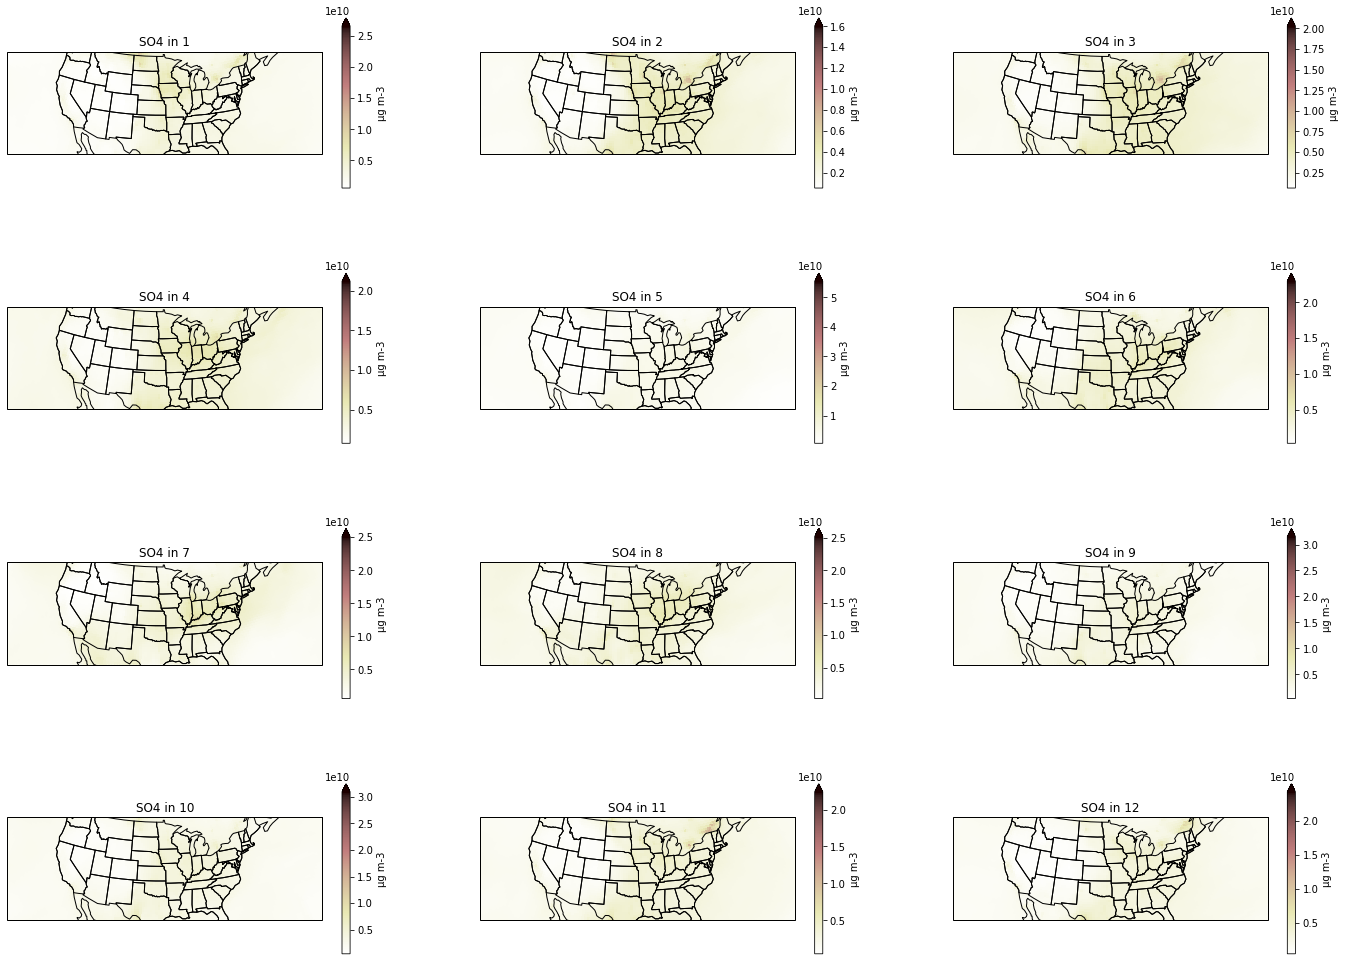

In [54]:
plotting.monthly_mean(ds.sel(model_name = 'normal_model'), 'SO4',np.arange(0,2e10,1e9), utils.lat_lon_dict['US_lat_lon'])

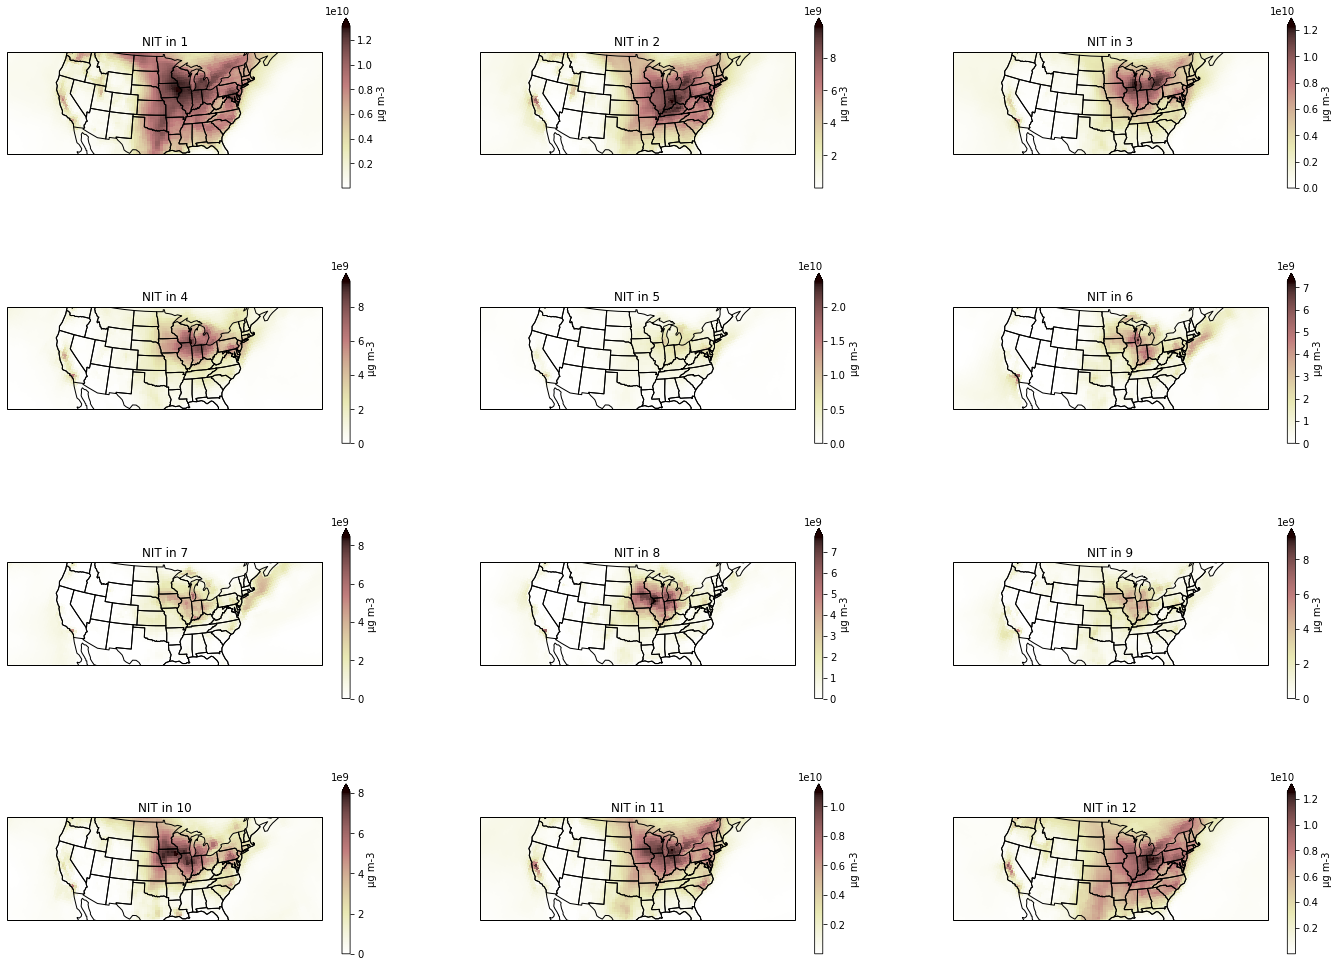

In [55]:
plotting.monthly_mean(ds.sel(model_name = 'normal_model'), 'NIT',np.arange(0,80,1), utils.lat_lon_dict['US_lat_lon'])